# Preprocessing

Импортируем библиотеки и прописываем пути, устанавливаем random_state.

In [1]:
import pandas as pd
import numpy as np
import scipy
import re

from tqdm import tqdm
from tqdm import notebook 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
import pickle

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

In [2]:
tqdm.pandas()

In [3]:
PATH_COVERS = 'data/raw/covers.json'
PATH_TRANSLETE_LYRICS = 'data/preprocessing/translated_lyrics.csv'
PATH_META = 'data/raw/meta.json'

PATH_SAVE_TRAIN_FAISS = 'data/preprocessing/train_faiss.csv'
PATH_SAVE_TEST_FAISS = 'data/preprocessing/test_faiss.csv'
PATH_SAVE_VALID_FAISS = 'data/preprocessing/valid_faiss.csv'

PATH_SAVE_TFIDFVECTORIZER = 'models/tfidf.pkl'

PATH_SAVE_TRAIN_CORPUS = 'data/preprocessing/train_corpus.npz'
PATH_SAVE_TEST_CORPUS = 'data/preprocessing/test_corpus.npz'
PATH_SAVE_VALID_CORPUS = 'data/preprocessing/valid_corpus.npz'

RANDOM_STATE = 54321

Напишем функцию, которая на вход будет принимать пути к нашим датасетам, проводить чистку данных и возвращать объединённый датасет. 

In [4]:
def get_united_df(path_covers: str, psth_lyrics: str, path_meta: str) -> pd.DataFrame:
    df_covers = pd.read_json(PATH_COVERS, lines=True)
    df_lyrics = pd.read_csv(psth_lyrics)[['track_id', 'language', 'translate_text']]
    df_meta = pd.read_json(PATH_META, lines=True, convert_dates=['dttm'])
    
    # проведём чистку датасетов переименуем с языком столбец в df_lyrics
    df_covers = df_covers.dropna()
    df_lyrics = df_lyrics.drop_duplicates(subset='track_id')
    df_meta = df_meta[df_meta['duration']!=0]
    df_lyrics = df_lyrics.rename(columns={'language': 'lyric_language'})
    
    df_union = (df_covers.merge(df_lyrics, on = 'track_id', how = 'inner')
                     .merge(df_meta, on = 'track_id', how = 'inner'))
    
    # в столбцах с пропусками в языках, возьмём данные из языка текста
    df_union.loc[df_union['language'].isna(), 'language'] = df_union.loc[df_union['language'].isna(), 'lyric_language']
    df_union = df_union.drop('lyric_language', axis=1)
    
    return df_union.dropna()

In [5]:
df_union = get_united_df(PATH_COVERS, PATH_TRANSLETE_LYRICS, PATH_META)
df_union.shape

(2986, 10)

У нас получился датасет из 2986 строк, в котором есть все требуемые данные.

Теперь нам нужно создать столбец в котором будут указаны все каверы / оригиналы для конкретного original_track_id и посчитать их количество

In [6]:
def make_covers_column(df: pd.DataFrame, count_cover=True) -> pd.DataFrame:
    df_new = df.copy(deep=True)
    df_group = df.groupby('original_track_id', as_index= False ).agg({'track_id': ' '. join})
    df_group = df_group.rename(columns = {'track_id': 'cover_list'})
    df_group['cover_list'] = df_group['cover_list'].str.split()
    
    # присоединим список с датасетом и удалим из списка сам трек
    df_new = df_new.merge(df_group, on = 'original_track_id', how='inner')
    df_new['cover_list'] = df_new.apply(lambda x: list(set(x['cover_list']) ^ {x['track_id']}), axis=1)
    
    if count_cover:
        df_new['cover_count'] = df_new['cover_list'].apply(lambda x: len(x))

    return df_new

In [7]:
df_union = make_covers_column(df_union)
df_union.head()

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,cover_count
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,"[ecc749ddb382d52c1161e517d878d8d6, b3728c3e3ba...",14
1,eeb69a3cb92300456b6a5f4162093851,14cd5aac84c43bf6830c8276c05ee2f8,COVER,Left a good job down in the city\nWorkin' for ...,2010-01-31 21:00:00,Proud Mary,EN,FRZ040600166,"[ROCK, ALLROCK]",395460.0,"[ecc749ddb382d52c1161e517d878d8d6, b3728c3e3ba...",14
2,eeb69a3cb92300456b6a5f4162093851,c99604698f81b2454389e8e3b6d3520b,COVER,"You know, every now and then I think you might...",2014-04-16 20:00:00,Proud Mary,EN,GBAYE9300862,"[POP, RNB]",327390.0,"[ecc749ddb382d52c1161e517d878d8d6, b3728c3e3ba...",14
3,eeb69a3cb92300456b6a5f4162093851,70ce45ec4414b7993d98718995456668,COVER,"Y' know, Every now and then\nI think You might...",2012-12-29 22:56:50,Proud Mary,EN,FR6V81426499,"[ELECTRONICS, LOUNGE]",190030.0,"[ecc749ddb382d52c1161e517d878d8d6, b3728c3e3ba...",14
4,eeb69a3cb92300456b6a5f4162093851,e58d2c71ff16648513a9c727281fb474,COVER,Left a good job in the city\nWorkin' for the m...,2013-11-16 06:24:08,Proud Mary,EN,FR6V80083191,"[ALLROCK, RNR]",155350.0,"[ecc749ddb382d52c1161e517d878d8d6, b3728c3e3ba...",14


Чтобы корректно разделить выборку, добавим столбец для стратификации, для этого выделим группы по количеству каверов у песни. Для этого построим гистограмму

<Axes: >

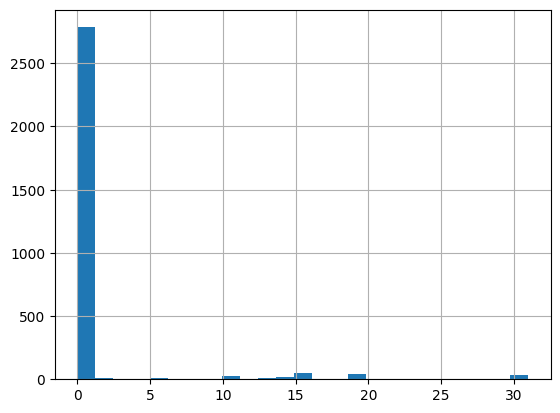

In [8]:
df_union['cover_count'].hist(bins=25)

Выделим следующие группы:
* количество каверов равное 0
* количество каверов от 1 до 5
* количество каверов от 5 до 15
* количество каверов больше 15

In [9]:
df_union.loc[df_union['cover_count']==0, 'group_count_cover'] = 'group_1'
df_union.loc[(df_union['cover_count']>0) &
             (df_union['cover_count']<=5), 'group_count_cover'] = 'group_2'
df_union.loc[(df_union['cover_count']>5) &
             (df_union['cover_count']<=15), 'group_count_cover'] = 'group_3'
df_union.loc[df_union['cover_count']>15, 'group_count_cover'] = 'group_4'

Удалим ненужный столбец cover_count

In [10]:
df_union = df_union.drop('cover_count', axis=1)

Разделим датасет на тренировочную, тестовую и валидационную выборки.

In [11]:
df_train, df_test = train_test_split(df_union,
                                     random_state=RANDOM_STATE,
                                     test_size=0.3,
                                     stratify=df_union['group_count_cover'])

In [12]:
df_train.shape, df_test.shape

((2090, 12), (896, 12))

In [13]:
df_test, df_valid = train_test_split(df_test,
                                     random_state=RANDOM_STATE,
                                     test_size=0.5,
                                     stratify=df_test['group_count_cover'])

In [14]:
df_test.shape, df_valid.shape

((448, 12), (448, 12))

Теперь удалим созданные столбцы и пересоздадим их заново (тренировочная выборка не должна ничего знать о тестовой и валидационной, а для тестовой и валидационной выборки нас будут интересовать количество каверов из трейна). 

In [15]:
df_train = df_train.drop(['cover_list', 'group_count_cover'], axis=1)

Для тестовой и валиадционной выборки удалим только столбец с группами, и найдём пересечение со списком track_id из трейновой выборки

In [16]:
df_test = df_test.drop(['group_count_cover'], axis=1)
df_valid = df_valid.drop(['group_count_cover'], axis=1)

Получим список каверов для трэйна 

In [17]:
df_train = make_covers_column(df_train, False)

Получим множество track_id в трэйновом датасете

In [18]:
set_train_track = set(df_train['track_id'].values)

Найдём пересечения данного множества со списками значений в cover_list

In [19]:
df_test['cover_list'] = df_test.apply(lambda x: list(set(x['cover_list']) & set_train_track), axis=1)
df_valid['cover_list'] = df_valid.apply(lambda x: list(set(x['cover_list']) & set_train_track), axis=1)

## Создание корпусов текста

Для обработки текста мы планируем воспользоваться TfIdf, но первоначально нам потребуется почистить текст. Для этого воспользуемся библиотекой nltk предварительно загрузив необходимые данные

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
lemmatizer = WordNetLemmatizer()

Создадим функцию, чтобы почистить текст и оставить только латиницу.

In [24]:
def clear_text(text: str) -> str:
    new_text = re.sub(r'[^a-zA-Z]', ' ', text)    
    new_text = new_text.split()
    new_text = new_text
    return ' '.join(new_text).lower()

Создадим функцию для лематизации текста.

In [25]:
def lemmatize(text: str) -> str:
    text_list = nltk.word_tokenize(text)
    lemm_list = []    
    for word in text_list:
        lemm_list.append(lemmatizer.lemmatize(word))    
    lemm_text = " ".join(lemm_list)        
    return lemm_text

Создадим функцию, которая на вход будет принимать датасет, столбец с текстом и проводить лематизацию в столбец lemm_text. Поскольку операцию может быть достаточно долгой, то будем проводить её по батчам

In [26]:
def lemmatize_df(df: pd.DataFrame, 
                 text_column: str, 
                 batch_size: int = 200) -> pd.DataFrame:
    df = df.copy(deep=True)
    df = df.reset_index(drop=True)
    df['lemm_text'] = ''
    for i in notebook.tqdm(range(df.shape[0] // batch_size)):
        n = i * batch_size
        df.loc[n:n + batch_size - 1, 'lemm_text'] = df.loc[n:n + batch_size - 1, text_column].apply(clear_text) 
        df.loc[n:n + batch_size - 1, 'lemm_text'] = df.loc[n:n + batch_size - 1, 'lemm_text'].apply(lemmatize) 
    return df

Преобразуем наши датасеты и выведем первые 5 строк датасета трейн

In [27]:
df_train = lemmatize_df(df_train, 'translate_text')
df_test = lemmatize_df(df_test, 'translate_text')
df_valid = lemmatize_df(df_valid, 'translate_text')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
df_train.head()

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,lemm_text
0,11ffce9da6aaa76f92173c8a802dd398,34ee25451b366a3747aa1fb99a137603,COVER,A broken heart is all that's left\nI'm still f...,2022-01-21 21:00:00,loving you is a losing game,EN,QZMEM2176959,[POP],100000.0,[11ffce9da6aaa76f92173c8a802dd398],a broken heart is all that s left i m still fi...
1,11ffce9da6aaa76f92173c8a802dd398,11ffce9da6aaa76f92173c8a802dd398,ORIGINAL,A broken heart is all that's left\nI'm still f...,2019-03-06 21:00:00,Arcade,EN,NL1TK1900001,[POP],185140.0,[34ee25451b366a3747aa1fb99a137603],a broken heart is all that s left i m still fi...
2,b129490dfeb0e08a12d1270363bfaff6,b129490dfeb0e08a12d1270363bfaff6,ORIGINAL,When you're thinking of the life you live\nThe...,2020-11-27 02:19:26,Ones You Miss,EN,AEA2D2000014,[DANCE],133660.0,[],when you re thinking of the life you live the ...
3,6088fd7fef860867caa9f6cc766a1f68,6088fd7fef860867caa9f6cc766a1f68,ORIGINAL,I do not know how you are everywhere now\nI wo...,2022-08-10 21:00:00,Худший друг,RU,AEA0D1828626,"[RUSRAP, RAP]",183390.0,[],i do not know how you are everywhere now i wou...
4,7fc4e1c328606cfa69d87e1dc001db85,f83c931d6fedf04539ee3fc12cdcde48,COVER,Dreams are carried away into the distance\nThe...,2019-05-21 20:19:30,Т. М. Н. И.,RU,RUA3R1915671,"[POP, RUSPOP]",202570.0,[],dream are carried away into the distance the c...


Сохраним данные датасеты, он потребуется на обучении модели (поскольку там будем подбирать параметры модели)

In [29]:
df_train.to_csv(PATH_SAVE_TRAIN_FAISS)
df_test.to_csv(PATH_SAVE_TEST_FAISS)
df_valid.to_csv(PATH_SAVE_VALID_FAISS)

Создадим корпусы для обучения

In [30]:
corpus_train = df_train['lemm_text']
corpus_test = df_test['lemm_text']
corpus_valid = df_valid['lemm_text']

Загрузим стоп слова для английского языка

In [31]:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обучим TfIdf и векторизуем наши корпуса. Пока будем передавать только стоп слова, но на этапе моделинга, попробуем подобрать оптимальные параметры для векторизтора

In [32]:
tf_idf = TfidfVectorizer(stop_words=stopwords)

In [33]:
%%time
corpus_train = tf_idf.fit_transform(corpus_train)
corpus_test = tf_idf.transform(corpus_test)
corpus_valid = tf_idf.transform(corpus_valid)

CPU times: total: 312 ms
Wall time: 320 ms


Выведем размеры получившихся корпусов

In [34]:
corpus_train.shape, corpus_test.shape, corpus_valid.shape

((2090, 11220), (448, 11220), (448, 11220))

In [35]:
type(corpus_train)

scipy.sparse._csr.csr_matrix

Сохраним обученный TfidfVectorizer

In [36]:
pickle.dump(tf_idf, open(PATH_SAVE_TFIDFVECTORIZER, "wb"))

Сохраним получившиеся корпуса. Поскольку это разреженные матрицы,  тонапишем функцию, которая будт их сохранять.

In [37]:
def save_sparse_csr(filename: str, array: scipy.sparse):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

In [38]:
save_sparse_csr(PATH_SAVE_TRAIN_CORPUS, corpus_train)
save_sparse_csr(PATH_SAVE_TEST_CORPUS, corpus_test)
save_sparse_csr(PATH_SAVE_VALID_CORPUS, corpus_valid)

## Выводы

В данном разделе был проведён препроцессинг данных в ходе которого:

1. Сформирован датасет для задачи кластеризации:
    * Использовались в основном сырые данные, кроме датасета с текстами, поскольку они дополнительно отдельно переводились на английский язык. Поскольку данная задача веьма трудозатратная, её выделили в отдельный ноутбук;
    * Данные были очищены, убраны все пропуски, поскольку для обучения модели кластеризации необходимо знать конкретные каверы или оригиналы для треков;
    * Добавлен целевой столбец, содержащий список каверов (оригиналов) для трека;
    * Данные были разделены на тренировочную, тестовую и валидационные выборки для стратификации был создан временный столбец с группировкой по количеству каверов; 
        
2. Проведена векторизация текстов:
    * Текст был очищен от лишних символов и проведена лематизация при помощи библиотекии nltk;
    * Обработанные датасеты были сохранены для дальнейшего использования на этапе моделинга;
    * Была проведена векторизация текстов при помощи TfidfVectorizer, на данном этапе в качестве параметров передавались только стоп слова.
    * Обученный TfidfVectorizer и векторизованные корпуса были так же сохранены для дальнейшего использования на этапе моделинга.